In [1]:
import sys
sys.path.append("../")

from transformers import AutoTokenizer
from models.clip import CLIPTextTransformer, CLIPVisionTransformer, CLIPModel

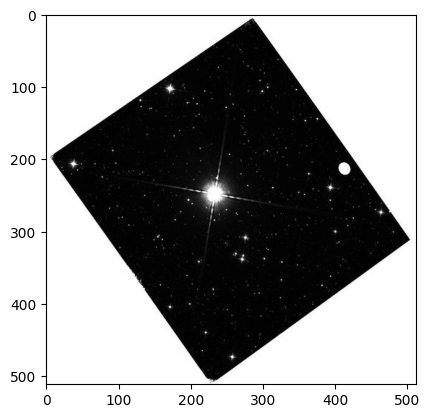

In [2]:
import sys
sys.path.append("../")

from models.dataset_utils import make_dataloader, create_input_iter

# files = ['../data/tfrecords/observations_1.tfrecord','../data/tfrecords/observations_2.tfrecord','../data/tfrecords/observations_3.tfrecord','../data/tfrecords/observations_4.tfrecord',]
files = ['../data/observations.tfrecord',]
ds = make_dataloader(files, batch_size=32, seed=42)
create_input_iter(ds)

image, caption = next(iter(ds))

import matplotlib.pyplot as plt
plt.imshow(image[0], vmin=0, vmax=1)

In [3]:
tokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-base-patch32")

caption = caption.numpy().tolist()
caption = [c.decode('utf-8') for c in caption]

txt_inputs = tokenizer(
                    caption,
                    padding="max_length",
                    truncation=True,
                    max_length=300,
                    return_tensors="np",
                )
txt_inputs = {k: txt_inputs[k] for k in ["input_ids", "attention_mask"]}

In [4]:
text_config = {
    "dtype": "float32",
    "activations": ["gelu"],
    "use_bias": False,
    "force_scale": False,
    "attention_dropout": 0.0,
    "mlp_dropout_rate": 0.0,
    "unroll": 100,
    "gradient_checkpointing": False,
    "eos_token_id": 49407,
    "vocab_size": 50000,
    "hidden_size": 512,
    "max_length": 300,
    "num_layers": 4,
    "use_rmsnorm": True,
    "ln_type": "normformer",
    "num_heads": 4,
    "position_embedding_type": "rotary",
    "use_causal_mask": False,
    "mlp_dim": 1024
  }

vision_config ={
  "position_embedding_type": "sincos2d",
  "dtype": "float32",
  "activations": ["gelu"],
  "use_bias": False,
  "force_scale": False,
  "attention_dropout": 0.0,
  "mlp_dropout_rate": 0.0,
  "unroll": 100,
  "gradient_checkpointing": True,
  "image_size": 512,
  "hidden_size": 512,
  "patch_size": 16,
  "num_layers": 4,
  "use_rmsnorm": True,
  "ln_type": "normformer",
  "num_heads": 4,
  "use_causal_mask": False,
  "mlp_dim": 1024
}

In [5]:
transformer = CLIPTextTransformer(**text_config)

In [6]:
txt_inputs['input_ids'].shape, txt_inputs['attention_mask'].shape

((32, 300), (32, 300))

In [142]:
import jax

key = jax.random.PRNGKey(0)
transformer.init_with_output(key, txt_inputs['input_ids'], txt_inputs['attention_mask']);

In [143]:
vit = CLIPVisionTransformer(**vision_config)

In [151]:
from PIL import Image
import jax.numpy as np
import matplotlib.pyplot as plt

outputs, params = vit.init_with_output(key, image.numpy());

In [156]:
num_local_devices = jax.local_device_count()

batch = {"pixel_values": image.numpy(), "input_ids": txt_inputs['input_ids'], "attention_mask": txt_inputs['attention_mask']}
batch = jax.tree_map(lambda x: np.array(x, dtype=np.float32), batch)
batch = jax.tree_map(lambda x: np.split(x, num_local_devices, axis=0), batch)

In [157]:
clip = CLIPModel(text_config=text_config, vision_config=vision_config, projection_dim=256)

outputs, params = clip.init_with_output(key, np.array(batch["input_ids"])[0], np.array(batch["pixel_values"])[0], np.array(batch["attention_mask"])[0])

In [158]:
import jax
import jax.numpy as np

# Enable float64 for numerical stability
jax.config.update("jax_enable_x64", True)

# def mini_batch_sigmoid_loss(text_embeds, image_embeds, logit_scale, logit_bias, negative_samples):

#     bs = text_embeds.shape[0]
    
#     if negative_samples:
#         labels = -np.ones((bs, bs))
#     else:
#         labels = 2 * np.eye(bs) - np.ones((bs, bs))
        
#     logits = np.matmul(text_embeds, image_embeds.T) * logit_scale + logit_bias
    
#     # Increase numerical stability
#     logits = logits.astype(np.float64)

#     # Use log_sigmoid for numerical stability
#     loss = -np.mean(jax.nn.log_sigmoid(labels * logits)) 
    
#     return loss

# def sigmoid_loss(outputs):

#     text_embeds = outputs["text_embeds"]
#     image_embeds = outputs["image_embeds"]
#     logit_scale = outputs["logit_scale"]
#     logit_bias = outputs["logit_bias"]

#     bs = text_embeds.shape[0]

#     # Compute positive loss
#     loss = mini_batch_sigmoid_loss(text_embeds, image_embeds, logit_scale, logit_bias, False)

#     # Negative pairs
#     shifted_image_embeds = [np.roll(image_embeds, -i, axis=0) for i in range(1, bs)]
#     shifted_image_embeds = np.stack(shifted_image_embeds)
    
#     all_neg_logits = np.einsum("bi,aji->abj", text_embeds, shifted_image_embeds)
#     all_neg_logits = all_neg_logits * logit_scale + logit_bias
#     all_neg_logits = all_neg_logits.astype(np.float64)

#     neg_labels = -np.ones(all_neg_logits.shape)
#     neg_loss = -np.mean(jax.nn.log_sigmoid(neg_labels * all_neg_logits))

#     loss += (bs - 1) * neg_loss
#     loss /= bs

#     return loss

In [159]:
def mini_batch_sigmoid_loss(text_embeds, image_embeds, logit_scale, logit_bias, negative_samples):
        """Positive samples are on the diagonal"""
        bs = text_embeds.shape[0]
        if negative_samples:
            labels = -np.ones((bs, bs))
        else:
            labels = 2 * np.eye(bs) - np.ones((bs, bs))
        logits = np.matmul(text_embeds, image_embeds.T) * logit_scale + logit_bias
        # Increase precision for large batches
        logits = logits.astype(np.float64)
        return -np.mean(jax.nn.log_sigmoid(labels * logits))

def sigmoid_loss(outputs):
        text_embeds = outputs["text_embeds"]
        image_embeds = outputs["image_embeds"]
        logit_scale = outputs["logit_scale"]
        logit_bias = outputs["logit_bias"]

        axis_size = jax.lax.psum(1, axis_name="batch")
    
        # Calculate local device loss
        loss = mini_batch_sigmoid_loss(text_embeds, image_embeds, logit_scale, logit_bias, negative_samples=False)

        # Add negative losses
        def add_negative_loss(i, carrys):
            cumul_loss, image_embeds = carrys
            
            # Shift image_embeds
            image_embeds = jax.lax.ppermute(
                image_embeds, axis_name="batch", perm=[(j, (j - 1) % axis_size) for j in range(axis_size)]
            )
            # Add loss (all negative samples)
            cumul_loss += mini_batch_sigmoid_loss(
                text_embeds, image_embeds, logit_scale, logit_bias, negative_samples=True
            )
            
            return cumul_loss, image_embeds

        loss, _ = jax.lax.fori_loop(0, axis_size - 1, add_negative_loss, (loss, image_embeds))
        loss = loss / axis_size

        loss = loss.reshape((-1,))

        # Average loss across devices
        loss = np.mean(loss)
        return loss

In [160]:
from functools import partial

@partial(jax.pmap, axis_name="batch")
def train_step(state, input_ids, images, attention_mask):
    """Train for a single step."""

    def loss_fn(params):
        outputs = state.apply_fn(params, input_ids, images, attention_mask)
        loss = sigmoid_loss(outputs)
        return loss


    loss, grads = jax.value_and_grad(loss_fn)(state.params)
    grads = jax.lax.pmean(grads, "batch")
    new_state = state.apply_gradients(grads=grads)
    metrics = {"loss": jax.lax.pmean(loss, "batch")}
    return new_state, metrics

In [161]:
import optax 
from flax.training import checkpoints, common_utils, train_state

import flax

replicate = flax.jax_utils.replicate
unreplicate = flax.jax_utils.unreplicate

tx = optax.adamw(learning_rate=1e-4)
state = train_state.TrainState.create(apply_fn=clip.apply, params=params, tx=tx)
pstate = replicate(state)

pstate, metrics = train_step(pstate, np.array(batch["input_ids"]), np.array(batch["pixel_values"]), np.array(batch["attention_mask"]))

In [162]:
metrics

{'loss': Array([0.80697355, 0.80697355, 0.80697355, 0.80697355], dtype=float64)}

In [128]:
metrics

{'loss': Array([0.80697355, 0.80697355, 0.80697355, 0.80697355], dtype=float64)}

In [163]:
np.array(batch["pixel_values"]).shape

(4, 8, 512, 512, 3)